# Se importa las librerías

In [43]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np
import scipy.stats as ss
from itertools import combinations
import re

In [2]:
## preguntar por las funciones de la librería sm y smf
## https://yuasaavedraco.github.io/Docs/Regresi%C3%B3n_Lineal_Simple_con_Python.html
## https://localcoder.org/stepwise-regression-in-python

# Pregunta 1:
Describa los datos, entregando gráficos y tablas que muestren las principales características de la base de
datos.
Ayuda: puede emplear el método .hist(bins=n_bins, figsize = (ancho, alto)) para graficar un resu-
men de histogramas de los datos.

## Se hace una transformación al archivo original para que pase a ser un csv

In [16]:
df=pd.read_csv('/Users/milan/crime_usa.csv',sep=';')
df.shape

(50, 7)

## Se revisa las correlaciones iniciales de las columnas del dataset 

<AxesSubplot:>

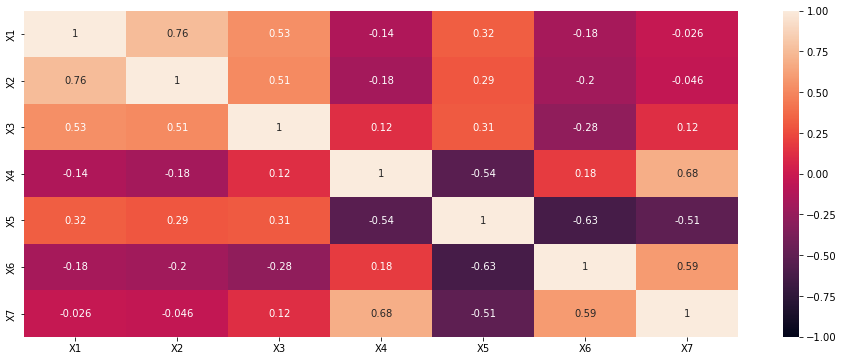

In [4]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

* Se muestra que las opciones X2,X3 y X5 tienen una correlación relativamente importante, por tanto estimo que serán significativas más adelante en el ejercicio

### Se hace un modelo de regresión linear múltiple sin una limpieza previa para ver sus resultados generales

* Se ocupan 2 funciones para estimar regresión lineal a la espera de confirmar cual es la diferencia entre ambas

In [17]:
x_corr=sm.add_constant(df[['X2','X3','X4','X5','X6','X7']])
y= df['X1']
regressor_OLS = sm.OLS(y,x_corr).fit()
regressor_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     X1   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     11.36
Date:                Wed, 11 May 2022   Prob (F-statistic):           1.42e-07
Time:                        23:05:51   Log-Likelihood:                -330.87
No. Observations:                  50   AIC:                             675.7
Df Residuals:                      43   BIC:                             689.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.3936    370.693      0.271      0.788    -647.180     847.968
X2             0.3323      0.060      5.574      0.000       0.212       0.453
X3             3.9982      2.682      1.490      0.143      -1.412       9.408
X4             1.8579      5.241      0.355      0.725      -8.711      12.427
X5             7.8389      7.760      1.010      0.318      -7.810      23.488
X6             2.5588      3.427      0.747      0.459      -4.352       9.470
X7            -3.2312     10.715     -0.302      0.764     -24.841      18.378
==============================================================================
Omnibus:                       23.696   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.825
Skew:                           1.411   Prob(JB):                     3.04e-10
Kurtosis:                       6.615   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
* Se obtiene que la R2 0.559 para la formula X1~X2+X3+X4+X5+X5+X7

## Se crea función para plotear rápidamente las columnas

In [7]:
def graficas_plot(nom,x):
    data_plt=x
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(nom)
    ax1 = fig.add_subplot(221)
    ax1.set_title('Gatito')
    ax1.boxplot(x, flierprops=dict(markerfacecolor='red', marker='o'), showmeans=True);
    ax2 = fig.add_subplot(222)

    ax2.hist(data_plt, density=True, bins=8, label="Data")
    mn = data_plt.min()
    mx = data_plt.max()
    rv = ss.norm(np.mean(data_plt), np.std(data_plt))
    x = np.linspace(mn,mx)
    ax2.set_title('Distribución')
    ax2.plot(x, rv.pdf(x), lw=2, color="blue");

### Se valida los valores de las columnas

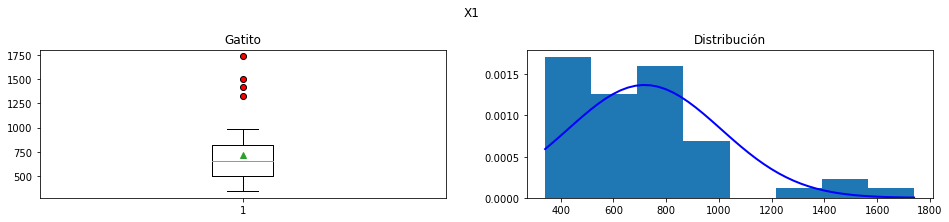

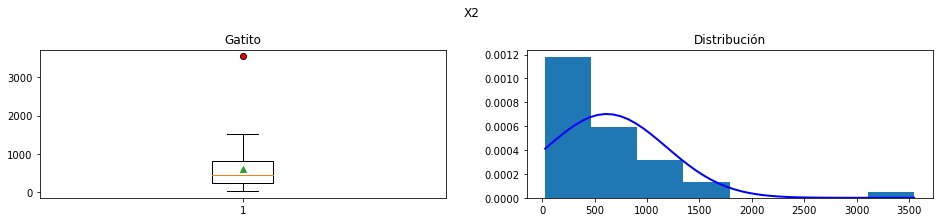

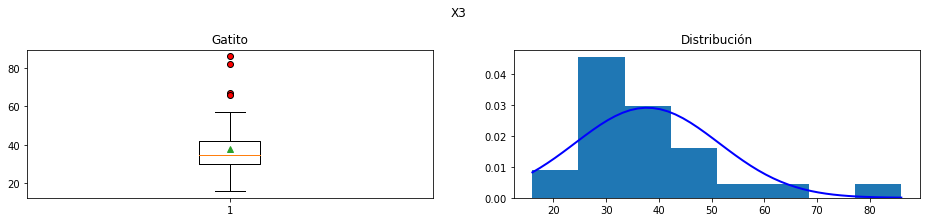

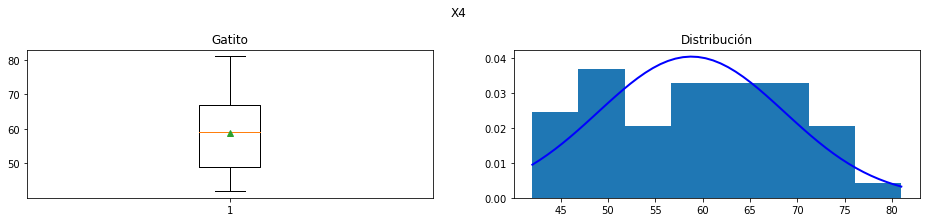

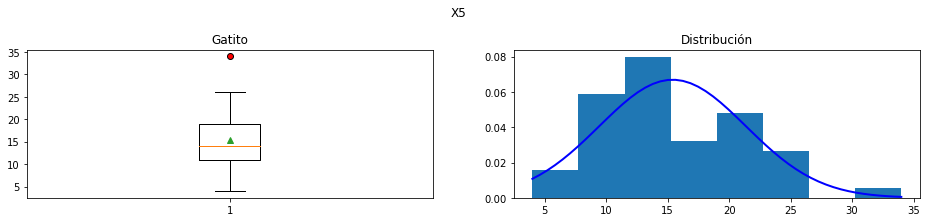

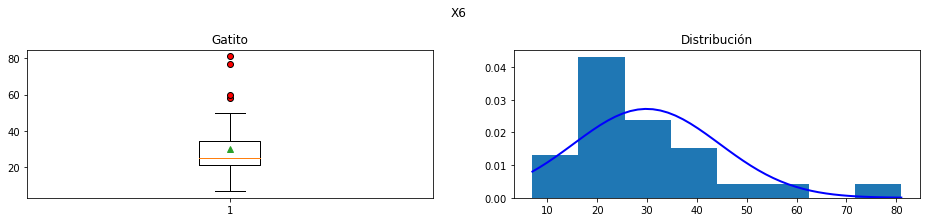

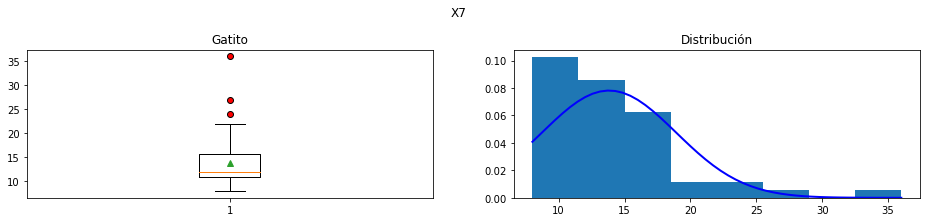

In [8]:
graficas_plot("X1",df['X1'])
graficas_plot("X2",df['X2'])
graficas_plot("X3",df['X3'])
graficas_plot("X4",df['X4'])
graficas_plot("X5",df['X5'])
graficas_plot("X6",df['X6'])
graficas_plot("X7",df['X7'])


* Se presenta que la mayoría de las variables predictoras estudiados tienen a tener OUTLINER con número excesimante grandes a diferencia de otras variables, esto se debe expresar a que el crimen y la consecuente lucha que se lleva contra ellas en ciertas ciudades de estados unidos se encuentra disparada.

**Se eliminó una sección del código donde validaba si era conveniente eliminar outliner, se llega a la conclusión de que quitar las outliner empeorá la calidad del modelo, esto puede estar causado por la poca cantidad de variables del modelo**

In [192]:
df[df['X2']>2000]

,X1,X2,X3,X4,X5,X6,X7
40,1740,3545,86,62,22,18,15


* Por ejemplo, validando este registro con un OUTLINER en la columna "X2 - Crimen violento cada 100K" (Máximo APROX esperado:1700 / Valor real 3545), podemos ver que también presenta OUTLINER en "X1 - Crimen reportado cada 1M " (Máximo APROX esperado:1000 / Valor real 1740) y "X3 - "

# Pregunta 2:
Efectúe un análisis de regresión lineal múltiple que explique la tasa de crímenes reportados totales por cada
1 millón de habitantes. Para esto, implemente la metodología de stepwise hacia atrás o hacia adelante, para
encontrar la mejor combinación de variables explicatorias. Puede emplear cualquier métrica de desempeño
de modelo: RMSE, R2, AIC, o BIC.
Ayuda: Todas las métricas, parámetros, y otros resultados relevantes pueden ser revisados a partir del objeto
 ́ ́model ́ ́, en donde quedan almacenados al crear algún modelo de regresión

### Se trata de hacer stepwise con la siguiente página hacia adelante usando la siguiente función recuperada desde un sitio web

In [193]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

model = forward_selected(df, 'X1')

print(model.model.formula)


print (model.rsquared_adj)

X1 ~ X2 + X3 + 1
0.5848856605529651


**Por medio de la función se llego a las siguientes conclusiones**
* La formula ideal es X1 ~ X2 + X3 + 1
* El R2 ajustado que se consigue es 0.5848856605529651

### Siguiendo las lógicas explicadas en clases creé el siguiente código que termina generando un DataFrame con las formulas

In [189]:
x=df[['X2','X3','X4','X5','X6','X7']]
y=df['X1']
lista={}
r2={}
pos_f=0
for pos,oi in enumerate(x):  
    temp = list(combinations(x, 1+pos))
    for posc,io in enumerate(temp):
        rt=[]
        for posh,ip in enumerate(io):
            rt.append(ip)
        apo = sm.OLS(y,sm.add_constant(x[rt])).fit()
        apo.model.endog_names
        apo.model.exog_names
        x_concat= ""
        for i in apo.model.exog_names:
            x_concat= x_concat+i+"+"
        lista[pos_f]=apo.model.endog_names+"~"+x_concat
        r2[pos_f]=apo.rsquared_adj
        pos_f=pos_f+1



d = {'Formula': lista, 'r2_adj': r2}

dg = pd.DataFrame(data=d)

dg.sort_values(by=['r2_adj'], ascending=False).head()

C:\Users\milan\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Formula,r2_adj
6,X1~const+X2+X3+,0.584886
22,X1~const+X2+X3+X5+,0.581754
21,X1~const+X2+X3+X4+,0.577626
44,X1~const+X2+X3+X5+X6+,0.577489
24,X1~const+X2+X3+X7+,0.576361


### Por medio del ejercicio llegue a concluir que la formula y el R2 Ajustado propuestos por el código es correcto, consiguiendo exactamente el mismo resultado.



# Pregunta 3
Muestre el resumen (summary()) del modelo escogido y describa sus principales características: - R2 - Esta-
dístico F - Estadístico t

* A continuación se muestra el sumario de la formula ganadora:

In [197]:
fin = sm.OLS(y,sm.add_constant(df[['X2','X3']])).fit()
fin.summary()

C:\Users\milan\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     X1   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     35.52
Date:                Thu, 12 May 2022   Prob (F-statistic):           4.00e-10
Time:                        02:26:32   Log-Likelihood:                -331.59
No. Observations:                  50   AIC:                             669.2
Df Residuals:                      47   BIC:                             674.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        350.8865     79.253      4.427      0.000     191.450     510.323
X2             0.3355      0.055      6.122      0.000       0.225       0.446
X3             4.2470      2.275      1.867      0.068      -0.329       8.823
==============================================================================
Omnibus:                       19.055   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.709
Skew:                           1.229   Prob(JB):                     5.83e-07
Kurtosis:                       5.782   Cond. No.                     2.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Conclusiones
* El mejor R2_adj es 0.585
* EL estadístico F es los bastante bajo para no entregar preocupación por los parametros.
* Los estadístico t son adecuados, aunque para X3 esta un poco baja.
* El valor de P para X3 es un poco más alta que 0,05.


# Pregunta 4: 
Comente sus resultados en función del problema. ¿Cuáles son las variables que mejor explican el problema
de la tasa de crimen en las ciudades de Estados Unidos?

* Me fijo que las variables del dataset las podríamos separar en 2 tipos:
 * las variables de "Abandono social" asociadas a factores de crimen y tasas de no educación en la población(X1,X2,X3,X5).
 * Las variables de "Diligencia social" asociadas principalmente a tasas sobre la educación en niveles medios y universitarios(X4,X6,X7).
* Habiendo una correlación alta entre X1 con las variables de abandono social (además que la combinación de variables en la regresión toman estas mismas variables) es claro que la falta de oportunidades para obtener una educación adecuada aumenta las tasas de criminalidad de las ciudades.
 * La falta de educación puede estar coartando las chances de superación de las personas.

In [198]:
df[df['X7']>30]

,X1,X2,X3,X4,X5,X6,X7
11,819,369,30,81,4,77,36


* Por ejemplo, en este registro donde vemos una tasa alta de personas de + de 25 años con estudios universitarios vemos que los valores de abandono social se encuentran dentro de los rangos esperados para su distribución, disponibles en el punto 1.
* Por el contrario puedo rescatar el mismo punto que vimos antes al inicio del documento y ver que los OUTLINER en variables de abandono social al ser altos dejan en rangos "aceptables/a la baja" en las variables de diligencia social.

In [199]:
df[df['X2']>2000]

,X1,X2,X3,X4,X5,X6,X7
40,1740,3545,86,62,22,18,15


* Sumado a que intente eliminar los OUTLINER dando como resultado el empobrecimiento del desempeño del dataset, da entender que estas variables son importantes.